# Basic Trendfit usage: fitting a time series with a break in the linear trend

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from trendfit.models import LinearBrokenTrendFourier
from trendfit.bootstrap import block_ar_wild

%matplotlib inline

## Synthetic data

Let's generate some ground truth time series using the model for this example.

In [2]:
def to_decimal_year(datetime):
    return datetime.year + (datetime.dayofyear - 1) / 365

# time series date range
date_rng = pd.date_range(start='1/1/2010', end='1/1/2020', freq='D')

# Fourier series truncated at order 3
ground_truth_model = LinearBrokenTrendFourier(f_order=3)

# Ground truth model parameters
t_break_true = to_decimal_year(pd.Timestamp('5/9/2016'))

ground_truth_model._parameters = {
    'trend': 1.,
    'fourier_terms': np.array([ 9.7,  21.1, -4.3, -0.5, -0.3, -1.7]),
    'intercept': -2000,
    't_break': t_break_true,
    'trend_change': 8
}

# Ground truth prediction 
y = ground_truth_model._predict(to_decimal_year(date_rng))

# Observational noise
y_o = y + np.random.normal(scale=18.0, size=date_rng.size)

# random sampling (unevenly spaced samples)
samples = np.sort(np.random.choice(date_rng.size, size=date_rng.size // 3, replace=False))

t = to_decimal_year(date_rng[samples]).values
data = y_o[samples]

Let's plot the time series. The dashed line represents the true breaking change in trend.

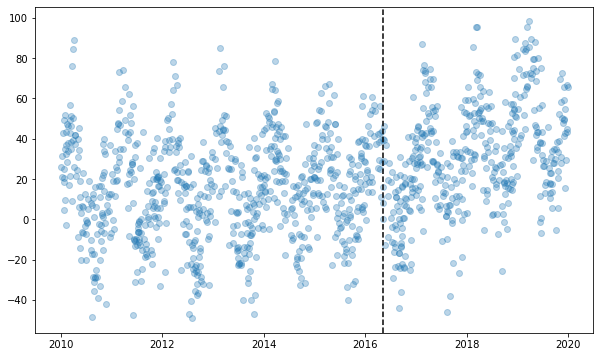

In [3]:
fig, ax = plt.subplots(figsize=(10, 6))

plt.scatter(t, data, alpha=0.3)
ax.axvline(t_break_true, linestyle='dashed', color='k');

## Model fitting

Let's use the data generated above and fit `LinearBrokenTrendFourier` parameters.

In [4]:
model = LinearBrokenTrendFourier(f_order=3)

In [5]:
res = model.fit(t, data)

/Users/bbovy/miniconda3/envs/trendfit_dev/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


`.fit` returns some information about the optimization process used to find the trend breaking date.

In [6]:
res

     fun: 396746.73490301124
 message: ['Maximum number of iteration reached']
    nfev: 1083
    nhev: 0
     nit: 500
    njev: 41
  status: 0
 success: True
       x: array([2016.55068491])

We can compare the fitted parameter values with the values chosen above to generate the data.

In [7]:
model.parameters

{'trend': 0.7214065829770817,
 't_break': 2016.5506849076405,
 'fourier_terms': array([10.79655742, 20.95464074, -4.50323095, -0.79480802, -2.10928567,
        -2.38491353]),
 'intercept': -1437.616915053864,
 'trend_change': 9.06784721960689}

Let's plot the results (blue: the data, red: the fitted model, solid line: the fitted trend breaking date, dashed line: the "true" trend breaking date).

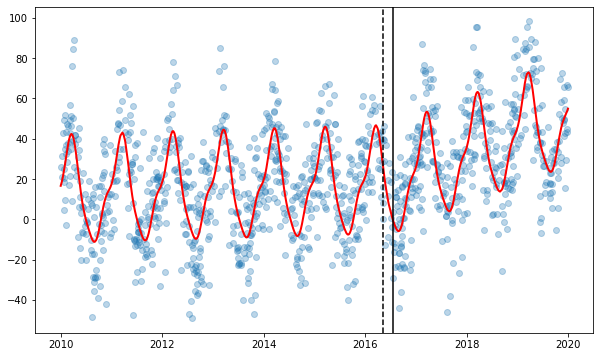

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(t, data, alpha=0.3)
ax.plot(t, model.predict(t), linewidth=2, color='r')
ax.axvline(model.parameters['t_break'], color='k')
ax.axvline(t_break_true, linestyle='dashed', color='k');

## Estimating model fitting uncertainty using bootstrap methods

From the fitted model above we can generate bootstrap samples (and repeat model fitting) to evaluate the uncertainty about the fitted parameter values. Here below we generate a few samples only to keep the computation fast. In real cases, however, the number of bootstrap samples should be higher for better accuracy.

In [9]:
boot_res = block_ar_wild(model, n_samples=50, use_cache=True)

/Users/bbovy/miniconda3/envs/trendfit_dev/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


From the bootstrap results we can extract confidence intervals for each fitted model parameter:

In [10]:
cf_intervals = boot_res.get_ci_bounds()

cf_intervals

{'trend': (0.022034072013003256, 1.3429917546703585),
 't_break': (2016.090890068394, 2017.078699034216),
 'fourier_terms': (array([ 9.84669849, 19.90972567, -5.69761058, -2.13050363, -3.25280899,
         -3.46574376]),
  array([12.1897336 , 22.31721075, -3.68568836,  0.35022574, -0.77479419,
         -1.20586055])),
 'intercept': (-2689.261035864747, -29.753315193906708),
 'trend_change': (7.548881397296048, 11.180884889047604)}

Let's re-generate the last plot and add the confidence interval on the trend breaking date (grey-filled area):

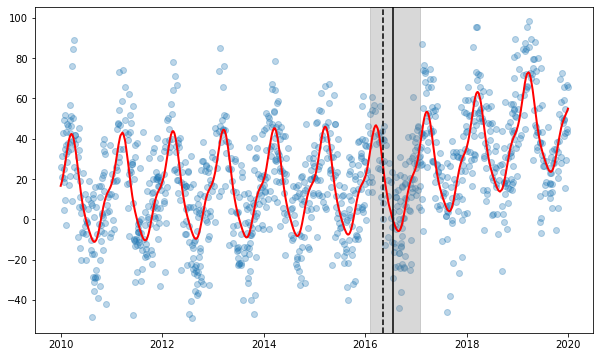

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(t, data, alpha=0.3)
ax.plot(t, model.predict(t), linewidth=2, color='r')

ax.axvline(model.parameters['t_break'], color='k')
ax.axvline(t_break_true, linestyle='dashed', color='k');
ax.axvspan(*cf_intervals['t_break'], color='grey', alpha=0.3);

Note that it is possible to generate the samples in parallel (using dask) to speed-up the computation, e.g.,

```python
with trendfit.set_options(use_dask=True):
    boot_res = block_ar_wild(model, n_samples=1000, block_size=500)
```
